In [1]:
!pip install blitz-bayesian-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.7 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from torch.utils.data import TensorDataset, DataLoader
from matplotlib.pyplot import scatter, figure
from scipy import stats
from numpy.ma.core import outer
from sys import stderr


In [4]:
start = -7
end = 7
n = 300
batch_size = 16

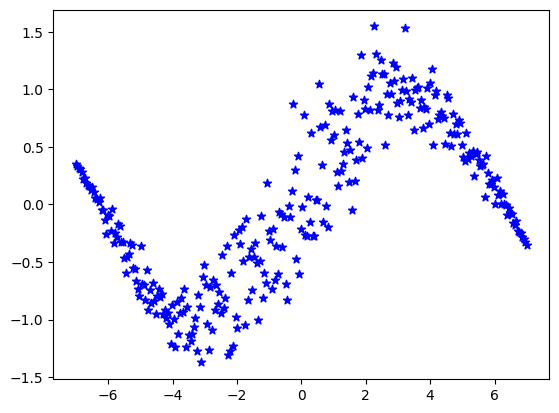

In [5]:
def sample_dataset(start, end, n):
    np.random.seed(0)
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs(random_state=0)
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

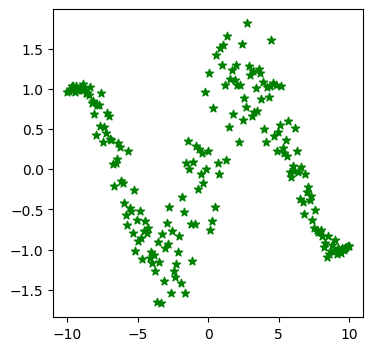

In [6]:
figure(figsize=(4, 4))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

In [7]:

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:


@variational_estimator
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        hidden_size = 29

        self.blinear1 = BayesianLinear(1, hidden_size, prior_sigma_1=1)
        self.blinear2 = BayesianLinear(hidden_size, hidden_size, prior_sigma_1=1)
        self.blinear3 = BayesianLinear(hidden_size, 1, prior_sigma_1=1)

    def forward(self, x):
        x_ = torch.relu(self.blinear1(x))
        x_ = torch.relu(self.blinear2(x_))
        return self.blinear3(x_)



In [9]:
def make_plot_bnn(model, samples = 500):
    preds = [model(tensor_x_test) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0).detach().numpy()
    stds =  preds.std(axis=0).detach().numpy()
    dfs = []
    y_vals = [means, means+2*stds, means-2*stds]

    for i in range(3):
      data = {
            "x": list(tensor_x_test.squeeze().numpy()),
            "y": list(y_vals[i].squeeze())
      }
      temp = pd.DataFrame.from_dict(data)
      dfs.append(temp)

    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot train data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.1)

    plt.show()

In [11]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
bnn = BayesianNetwork()
print(bnn)
print("Params:", sum(p.numel() for p in bnn.parameters() if p.requires_grad))
bnn.train()
bnn.to(device)
optimizer = optim.Adam(bnn.parameters(), lr=0.01)


BayesianNetwork(
  (blinear1): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (blinear2): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
  (blinear3): BayesianLinear(
    (weight_sampler): TrainableRandomDistribution()
    (bias_sampler): TrainableRandomDistribution()
    (weight_prior_dist): PriorWeightDistribution()
    (bias_prior_dist): PriorWeightDistribution()
  )
)
Params: 3832


In [30]:
def MLE_bnn():
  bnn=BayesianNetwork()
  criterion =torch.nn.MSELoss()
  optimizer = optim.Adam(bnn.parameters(), lr=0.001)
  bnn.train()
  bnn.to(device)
  for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()

        # See https://arxiv.org/pdf/1505.05424.pdf for complexity cost weight
        loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=0.01/len(train_dataset))

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        all_test_losses = []

        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             loss = bnn.sample_elbo(inputs=x,
                           labels=y,
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=0.01/len(test_dataset))
             all_test_losses.append(loss.item())


        test_loss = sum(all_test_losses)/len(all_test_losses)


  make_plot_bnn(bnn)
  print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")

  return loss, test_loss


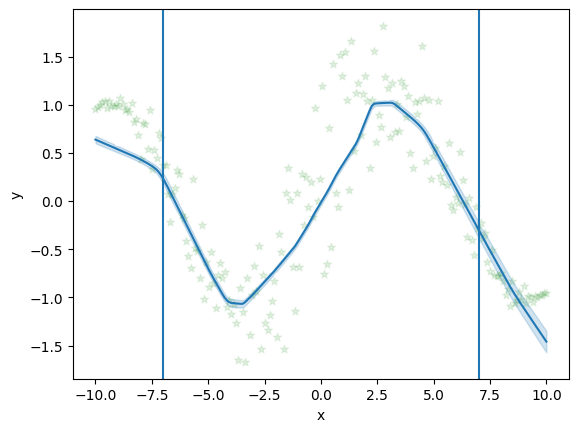

Epoch 149 | batch train loss: 0.23808491230010986 | test loss: 0.36935755839714635


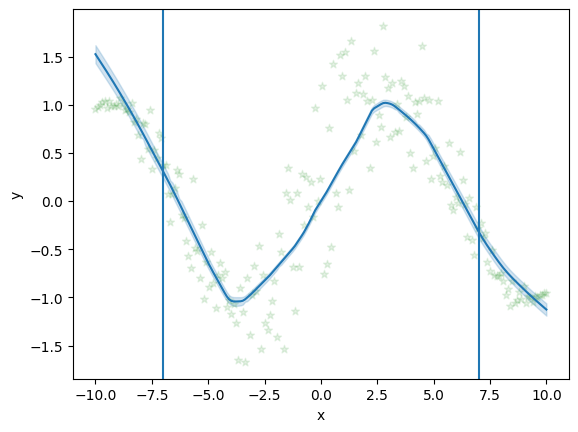

Epoch 149 | batch train loss: 0.1555153727531433 | test loss: 0.35248083105454076


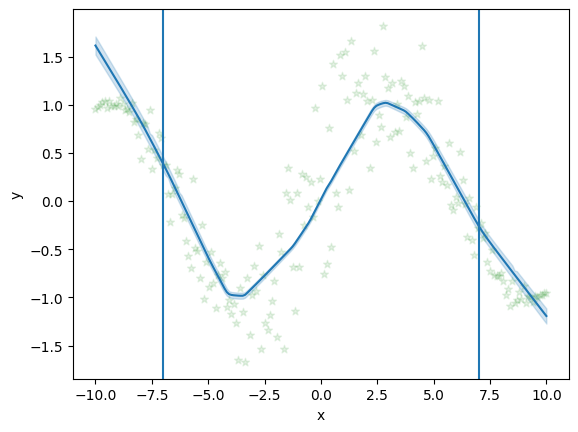

Epoch 149 | batch train loss: 0.2618841826915741 | test loss: 0.3452286273241043


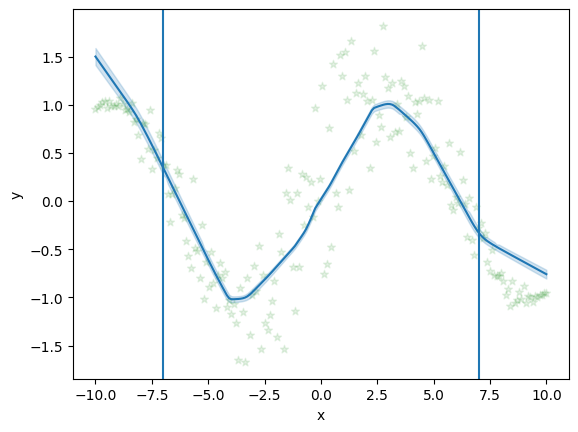

Epoch 149 | batch train loss: 0.16693130135536194 | test loss: 0.36368547723843503


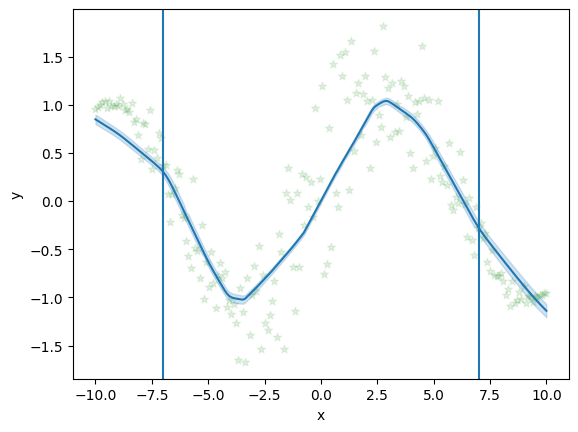

Epoch 149 | batch train loss: 0.18705525994300842 | test loss: 0.3626232445240021


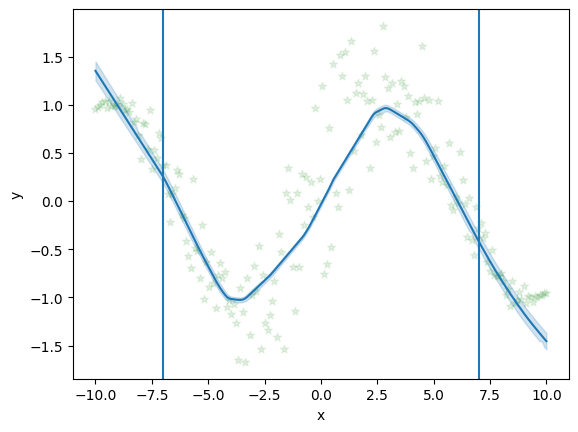

Epoch 149 | batch train loss: 0.23725563287734985 | test loss: 0.35569406816592586


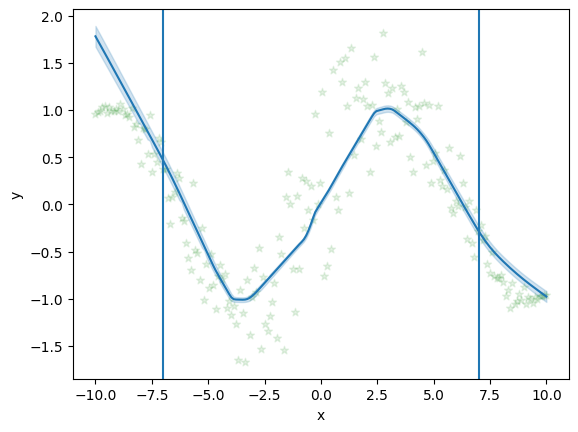

Epoch 149 | batch train loss: 0.23727315664291382 | test loss: 0.3540943769308237


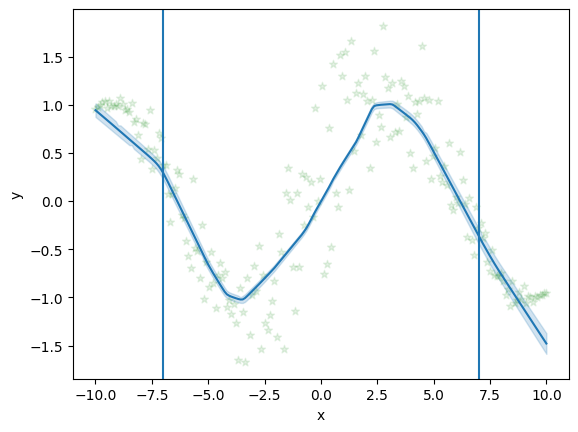

Epoch 149 | batch train loss: 0.18528808653354645 | test loss: 0.3478289842605591


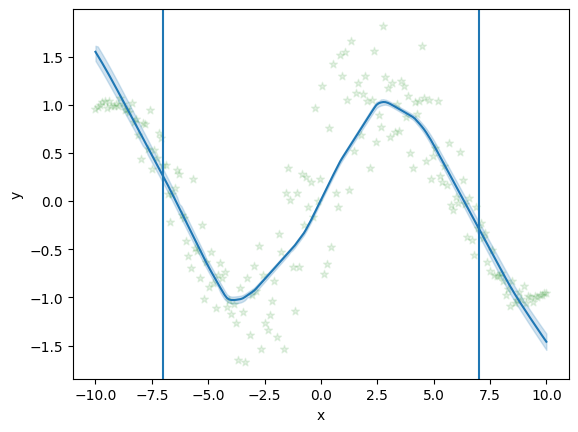

Epoch 149 | batch train loss: 0.2040439397096634 | test loss: 0.36252720997883725


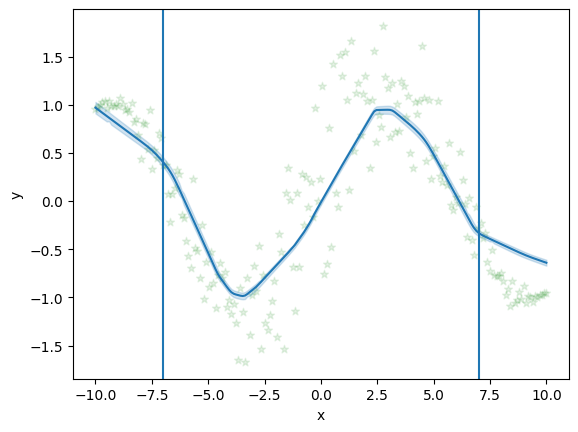

Epoch 149 | batch train loss: 0.16508734226226807 | test loss: 0.37068226360357726


In [31]:
train_losses=[]
test_losses=[]

for i in range(10):
  tr_loss,test_loss = MLE_bnn()
  train_losses.append(tr_loss)
  test_losses.append(test_loss)


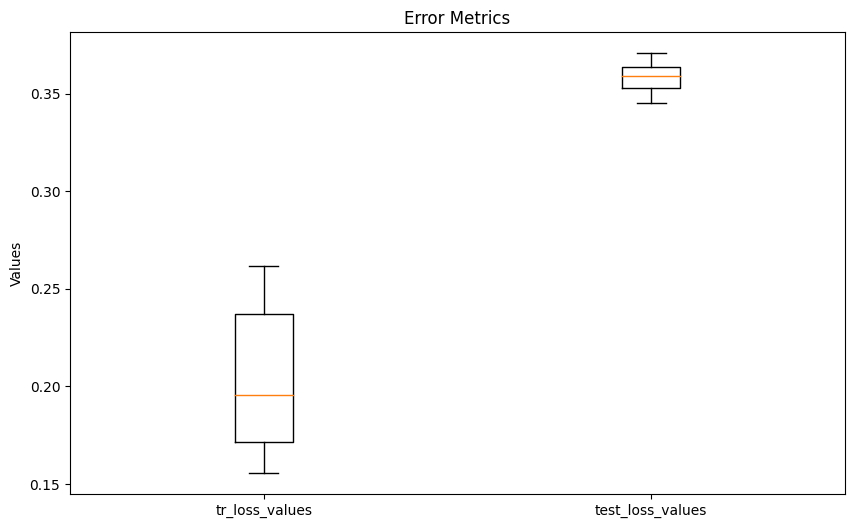

In [32]:
# Extract numerical values from the tensors and remove grad_fn
tr_loss_values= [tensor.item() for tensor in train_losses]
test_loss_values=test_losses

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plots for each dataset
box_plot_data = [tr_loss_values, test_loss_values]
box_labels = ['tr_MSE', 'test_MSE']

ax.boxplot(box_plot_data, labels=box_labels)

# Add labels and title

ax.set_ylabel('Values')
ax.set_title('Error Metrics')

# Show the plot
plt.show()


In [35]:
# Create a DataFrame from the lists
data = {
    'Training Loss': tr_loss_values,
    'Testing Loss': test_loss_values,

}

num_columns = len(data)

column_names = ['Training Loss','Testing Loss']

# Create a DataFrame with dynamic column names
df = pd.DataFrame(data, columns=column_names)
df.index += 1
# Display the DataFrame as a table
print(df)

    Training Loss  Testing Loss
1        0.238085      0.369358
2        0.155515      0.352481
3        0.261884      0.345229
4        0.166931      0.363685
5        0.187055      0.362623
6        0.237256      0.355694
7        0.237273      0.354094
8        0.185288      0.347829
9        0.204044      0.362527
10       0.165087      0.370682
